In [ ]:
###DATA PREPROCESSING###

In [1]:
#doublons
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql.dataframe import DataFrame
from pyspark.sql import Row as row , DataFrameStatFunctions as statFunc
from pyspark.sql.types import *

#sc.stop()

sc = SparkContext('local')
spark = SparkSession(sc)

df = spark.read.csv('airport.txt')

In [3]:
df.distinct().count()

7698

In [11]:
def spark_shape(self):
    return (self.count(), len(self.columns))
DataFrame.shape = spark_shape

In [4]:
df.shape()

(7698, 14)

In [6]:
def change_name_columns(self , value):
    return self.columns = value
DataFrame.name_columns change_name_columns

SyntaxError: invalid syntax (<ipython-input-6-4947c794729d>, line 2)

In [8]:
name_columns = ["c"+str(elt) for elt in range(df.shape()[1])]
#df.columns = name_columns

In [7]:
#df.columns

In [44]:
all_deleted = df.dropDuplicates()

In [43]:
(
df
    .groupBy(df.columns)
    .count()
    .filter("count > 1")
    .show()
    
)

+---+---+---+---+---+---+---+---+---+---+----+----+----+----+-----+
|_c0|_c1|_c2|_c3|_c4|_c5|_c6|_c7|_c8|_c9|_c10|_c11|_c12|_c13|count|
+---+---+---+---+---+---+---+---+---+---+----+----+----+----+-----+
+---+---+---+---+---+---+---+---+---+---+----+----+----+----+-----+



In [45]:
(
all_deleted.
groupby([col for col in all_deleted.columns if col != '_c0'])
.count()
.filter('count > 1')
.show()
)

+---+---+---+---+---+---+---+---+---+----+----+----+----+-----+
|_c1|_c2|_c3|_c4|_c5|_c6|_c7|_c8|_c9|_c10|_c11|_c12|_c13|count|
+---+---+---+---+---+---+---+---+---+----+----+----+----+-----+
+---+---+---+---+---+---+---+---+---+----+----+----+----+-----+



In [ ]:
#gestion des valeurs manquantes

In [16]:
#calcul du nombre d observations manquantes dans une ligne

spark.createDataFrame(
    df.rdd.map(lambda row:(row["_c0"] , sum([c == None for c in row]))
              ).collect() , ["id" , "count_missing"]
   ).orderBy("count_missing" , ascending = False).show(2)




+-----+-------------+
|   id|count_missing|
+-----+-------------+
|11794|            1|
|11900|            1|
+-----+-------------+
only showing top 2 rows



In [27]:
df.dropna().show(2)
df.dtypes

df_new = df.withColumn("_c0", df["_c0"].cast(IntegerType()))
df_new = df_new.withColumn("_c6", df["_c6"].cast(FloatType()))
df_new = df_new.withColumn("_c7", df["_c7"].cast(FloatType()))
df_new = df_new.withColumn("_c8", df["_c8"].cast(IntegerType()))
df_new = df_new.withColumn("_c9", df["_c9"].cast(IntegerType()))

df_new.dtypes

+---+--------------+------+----------------+---+----+------------------+-------------+----+---+----+--------------------+-------+-----------+
|_c0|           _c1|   _c2|             _c3|_c4| _c5|               _c6|          _c7| _c8|_c9|_c10|                _c11|   _c12|       _c13|
+---+--------------+------+----------------+---+----+------------------+-------------+----+---+----+--------------------+-------+-----------+
|  1|Goroka Airport|Goroka|Papua New Guinea|GKA|AYGA|-6.081689834590001|145.391998291|5282| 10|   U|Pacific/Port_Moresby|airport|OurAirports|
|  2|Madang Airport|Madang|Papua New Guinea|MAG|AYMD|    -5.20707988739|145.789001465|  20| 10|   U|Pacific/Port_Moresby|airport|OurAirports|
+---+--------------+------+----------------+---+----+------------------+-------------+----+---+----+--------------------+-------+-----------+
only showing top 2 rows



[('_c0', 'int'),
 ('_c1', 'string'),
 ('_c2', 'string'),
 ('_c3', 'string'),
 ('_c4', 'string'),
 ('_c5', 'string'),
 ('_c6', 'float'),
 ('_c7', 'float'),
 ('_c8', 'int'),
 ('_c9', 'int'),
 ('_c10', 'string'),
 ('_c11', 'string'),
 ('_c12', 'string'),
 ('_c13', 'string')]

In [29]:
#df_new.dtypes

In [ ]:
#traitement des valeurs aberrantes

In [32]:
features = ["_c6" , "_c7" , "_c8" , "_c9"]
quantiles = [0.25 , 0.75] #intervalle de normallité
cutOfPoints = []

for feature in features:
    qts = statFunc(df_new).approxQuantile(feature , quantiles , 0.05)
    IQR = qts[1] - qts[0]
    
    cutOfPoints.append((feature , [qts[0] - 1.5 * IQR , qts[1] + 1.5 * IQR]))
    
cutOfPoints = dict(cutOfPoints)


In [34]:
#signalement des points aberrants

outliers = df_new.select(*["_c0"] +[
    (
        (df_new[f] < cutOfPoints[f][0])|(df_new[f] > cutOfPoints[f][1])
    ).alias(f + '_b') for f in features
        ])
outliers.show(5)

+---+-----+-----+-----+-----+
|_c0|_c6_b|_c7_b|_c8_b|_c9_b|
+---+-----+-----+-----+-----+
|  1|false|false| true|false|
|  2|false|false|false|false|
|  3|false|false| true|false|
|  4|false|false|false|false|
|  5|false|false|false|false|
+---+-----+-----+-----+-----+
only showing top 5 rows



In [36]:
df_new.select(*["_c0"] + ["_c6"] + ["_c7"] + ["_c8"] + ["_c9"]).show(5)

+---+---------+---------+----+---+
|_c0|      _c6|      _c7| _c8|_c9|
+---+---------+---------+----+---+
|  1| -6.08169|  145.392|5282| 10|
|  2| -5.20708|  145.789|  20| 10|
|  3| -5.82679|  144.296|5388| 10|
|  4|-6.569803|146.72598| 239| 10|
|  5| -9.44338|   147.22| 146| 10|
+---+---------+---------+----+---+
only showing top 5 rows



In [54]:
withOutliersFlag = df_new.join(outliers , on = "_c0")

(
    withOutliersFlag.filter("_c8_b").select("_c0" ,"_c6","_c7", "_c8","_c9").show(5)
)

+---+--------+--------+----+---+
|_c0|     _c6|     _c7| _c8|_c9|
+---+--------+--------+----+---+
|  1|-6.08169| 145.392|5282| 10|
|  3|-5.82679| 144.296|5388| 10|
| 38|  52.075|-111.445|2595| -7|
| 43| 61.3711|-139.041|2647| -8|
| 46| 58.4222|-130.032|2600| -8|
+---+--------+--------+----+---+
only showing top 5 rows



In [55]:
df_no_outliers = (withOutliersFlag.filter("!_c8_b").select(df_new.columns))

df_no_outliers.show(2)

+---+--------------+------+----------------+---+----+---------+---------+---+---+----+--------------------+-------+-----------+
|_c0|           _c1|   _c2|             _c3|_c4| _c5|      _c6|      _c7|_c8|_c9|_c10|                _c11|   _c12|       _c13|
+---+--------------+------+----------------+---+----+---------+---------+---+---+----+--------------------+-------+-----------+
|  2|Madang Airport|Madang|Papua New Guinea|MAG|AYMD| -5.20708|  145.789| 20| 10|   U|Pacific/Port_Moresby|airport|OurAirports|
|  4|Nadzab Airport|Nadzab|Papua New Guinea|LAE|AYNZ|-6.569803|146.72598|239| 10|   U|Pacific/Port_Moresby|airport|OurAirports|
+---+--------------+------+----------------+---+----+---------+---------+---+---+----+--------------------+-------+-----------+
only showing top 2 rows



In [ ]:
#exploration statistiques

In [56]:
df_no_outliers_decriptive = df_no_outliers.describe().show()

+-------+------------------+--------------------+--------------------+-----------+----+----+------------------+-------------------+-----------------+------------------+----+--------------+-------+-----------+
|summary|               _c0|                 _c1|                 _c2|        _c3| _c4| _c5|               _c6|                _c7|              _c8|               _c9|_c10|          _c11|   _c12|       _c13|
+-------+------------------+--------------------+--------------------+-----------+----+----+------------------+-------------------+-----------------+------------------+----+--------------+-------+-----------+
|  count|              6696|                6696|                6650|       6696|6696|6696|              6696|               6696|             6696|              6380|6696|          6696|   6696|       6696|
|   mean| 5163.469384707288|                null|                 NaN|       null| NaN|null| 27.33809882887637|-1.0841226328823081|490.0800477897252|0.2717868338557

In [51]:
type(df_no_outliers)

pyspark.sql.dataframe.DataFrame

In [57]:
df_no_outliers_decriptive_features = df_no_outliers.describe(features).show()

+-------+------------------+-------------------+-----------------+------------------+
|summary|               _c6|                _c7|              _c8|               _c9|
+-------+------------------+-------------------+-----------------+------------------+
|  count|              6696|               6696|             6696|              6380|
|   mean| 27.33809882887637|-1.0841226328823081|490.0800477897252|0.2717868338557994|
| stddev|28.360284202348286|  87.57544649276171|575.0499653057253| 5.746659732097924|
|    min|          -77.9634|           -179.877|            -1266|               -12|
|    max|              89.5|            179.951|             2395|                13|
+-------+------------------+-------------------+-----------------+------------------+



In [ ]:
#computer correlation

In [60]:
correlation = (
df_no_outliers.corr("_c6","_c8"))

correlation1 = (
df_no_outliers.corr("_c7","_c8"))

correlation2 = (
df_no_outliers.corr("_c9","_c8"))

correlation3 = (
df_no_outliers.corr("_c8","_c8"))

In [62]:
correlation , correlation1 , correlation2 , correlation3

(0.026252312544448046, -0.11573647506133831, -0.11397391328357695, 1.0)

In [68]:
n_features = len(features)

corr = []

for i in range(0,n_features):
    temp = [None]*i
    
    for j in  range(i , n_features):
        temp.append(df_no_outliers.corr(features[i] , features[j]))
    corr.append([features[i]] + temp)
    
correlation = spark.createDataFrame(corr , ["column"] + features).show()

+------+----+------------------+--------------------+--------------------+
|column| _c6|               _c7|                 _c8|                 _c9|
+------+----+------------------+--------------------+--------------------+
|   _c6| 1.0|-0.291858937870911|0.026252312544448046| -0.2925716634805958|
|   _c7|null|               1.0|-0.11573647506133831|  0.9366390396299419|
|   _c8|null|              null|                 1.0|-0.11397391328357694|
|   _c9|null|              null|                null|                 1.0|
+------+----+------------------+--------------------+--------------------+



In [67]:
correlation

DataFrame[column: string, _c6: double, _c7: double, _c8: double, _c9: double]

In [120]:
##rename columns dataframe 

df_no_outliers2 = df_no_outliers.withColumnRenamed("_c0" , "Airport_ID")\
.withColumnRenamed("_c1" ,"Name")\
.withColumnRenamed("_c2","City")\
.withColumnRenamed("_c3", "Country")\
.withColumnRenamed("_c4","IATA")\
 .withColumnRenamed("_c5","ICAO")\
.withColumnRenamed("_c6","Lat")\
.withColumnRenamed("_c7","Long")\
.withColumnRenamed("_c8","Alt")\
.withColumnRenamed("_c9","TimeZone")\
.withColumnRenamed("_c10","DST")\
.withColumnRenamed("_c11","TZ database")\
.withColumnRenamed("_c12","Type")\
.withColumnRenamed("_c13","Source")

In [119]:
df_no_outliers2.printSchema()

root
 |-- Airport_ID: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- IATA: string (nullable = true)
 |-- ICAO: string (nullable = true)
 |-- Lat: float (nullable = true)
 |-- Long: float (nullable = true)
 |-- Alt: integer (nullable = true)
 |-- TimeZone: integer (nullable = true)
 |-- DST: string (nullable = true)
 |-- TZ database: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Source: string (nullable = true)



In [ ]:
####LINEAR REGRESSION####

In [81]:
from sklearn.datasets import load_boston
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.ml.regression import LinearRegression

spark2 = SparkSession.builder.appName('pandasToSparkDF').getOrCreate()

data = load_boston()
pdf = pd.DataFrame(data.data, columns=data.feature_names)
pdf.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [82]:
myschema  = StructType([ StructField("CRIM", DoubleType(), True)\
                       ,StructField("ZN", DoubleType(), True)\
                       ,StructField("INDUS", DoubleType(), True)\
                       ,StructField("CHAS", DoubleType(), True)\
                       ,StructField("NOX", DoubleType(), True)\
                       ,StructField("RM", DoubleType(), True)\
                       ,StructField("AGE", DoubleType(), True)\
                       ,StructField("DIS", DoubleType(), True)\
                       ,StructField("RAD", DoubleType(), True)\
                       ,StructField("TAX", DoubleType(), True)\
                       ,StructField("PRATIO", DoubleType(), True)\
                       ,StructField("B", DoubleType(), True)\
                       ,StructField("LSTAT", DoubleType(), True)])

In [88]:
df_boston = spark.createDataFrame(pdf , schema=myschema)

In [89]:
df_boston.show(2)

+-------+----+-----+----+-----+-----+----+------+---+-----+------+-----+-----+
|   CRIM|  ZN|INDUS|CHAS|  NOX|   RM| AGE|   DIS|RAD|  TAX|PRATIO|    B|LSTAT|
+-------+----+-----+----+-----+-----+----+------+---+-----+------+-----+-----+
|0.00632|18.0| 2.31| 0.0|0.538|6.575|65.2|  4.09|1.0|296.0|  15.3|396.9| 4.98|
|0.02731| 0.0| 7.07| 0.0|0.469|6.421|78.9|4.9671|2.0|242.0|  17.8|396.9| 9.14|
+-------+----+-----+----+-----+-----+----+------+---+-----+------+-----+-----+
only showing top 2 rows



In [90]:
df_boston.shape()
#df_boston.describe(3,False)

(506, 13)

In [164]:
df_boston.describe().show(3 , False)

+-------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+
|summary|CRIM              |ZN                |INDUS             |CHAS              |NOX                |RM                |AGE               |DIS              |RAD              |TAX               |PRATIO            |B                 |LSTAT             |
+-------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+
|count  |506               |506               |506               |506               |506                |506               |506               |506              |506              |506               |506               |506            

In [85]:
print(df_boston.corr("CRIM","DIS") , df_boston.corr("RM","DIS") , df_boston.corr("TAX","DIS"))

-0.37967008695102467 0.20524621293005416 -0.5344315844084577


In [91]:
from pyspark.ml.feature import VectorAssembler
vec_assemblor = VectorAssembler(inputCols = ["CRIM","ZN","INDUS","CHAS","NOX","RM","AGE","DIS","RAD","TAX","PRATIO","B","LSTAT"]
  , outputCol = "features")

In [92]:
features_df_boston = vec_assemblor.transform(df_boston)
features_df_boston.printSchema()

model_df_boston = features_df_boston.select("features" , "DIS")
model_df_boston.show(3)

root
 |-- CRIM: double (nullable = true)
 |-- ZN: double (nullable = true)
 |-- INDUS: double (nullable = true)
 |-- CHAS: double (nullable = true)
 |-- NOX: double (nullable = true)
 |-- RM: double (nullable = true)
 |-- AGE: double (nullable = true)
 |-- DIS: double (nullable = true)
 |-- RAD: double (nullable = true)
 |-- TAX: double (nullable = true)
 |-- PRATIO: double (nullable = true)
 |-- B: double (nullable = true)
 |-- LSTAT: double (nullable = true)
 |-- features: vector (nullable = true)

+--------------------+------+
|            features|   DIS|
+--------------------+------+
|[0.00632,18.0,2.3...|  4.09|
|[0.02731,0.0,7.07...|4.9671|
|[0.02729,0.0,7.07...|4.9671|
+--------------------+------+
only showing top 3 rows



In [191]:
train_df_boston , test_df_boston = model_df_boston.randomSplit([0.8 , 0.2] , 4)

In [192]:
train_df_boston.shape()
train_df_boston.count()

403

In [194]:
linear_regression = LinearRegression(labelCol="DIS")

lr_model = linear_regression.fit(train_df_boston)

print(lr_model.coefficients , lr_model.intercept)

[6.987552288395566e-17,-7.62626257746484e-17,1.7387931089766324e-16,1.738356430930479e-16,1.3167805178649045e-14,7.744593310346245e-16,5.673749129980831e-17,1.0000000000000027,2.995873698116672e-17,-2.300294784264346e-18,-9.661230126470572e-17,8.4519148551547055e-19,-4.140164240606481e-17] -2.491298242774532e-14


In [195]:
training_predictions = lr_model.evaluate(train_df_boston)

print("r2-score training:" , training_predictions.r2)

r2-score : 1.0


In [197]:
test_predictions = lr_model.evaluate(test_df_boston)

print("r2-score test:" , test_predictions.r2)
print(test_predictions.meanSquaredError)

r2-score test: 1.0
7.797181605063751e-30


In [ ]:
####LOGISTIC REGRESSION####

In [119]:
myschema  = StructType([ StructField("Loan_ID", StringType(), True)\
                       ,StructField("Gender", StringType(), True)\
                       ,StructField("Married", StringType(), True)\
                       ,StructField("Dependents", DoubleType(), True)\
                       ,StructField("Education", StringType(), True)\
                       ,StructField("Self_Employed", StringType(), True)\
                       ,StructField("ApplicantIncome", DoubleType(), True)\
                       ,StructField("CoapplicantIncome", DoubleType(), True)\
                       ,StructField("LoanAmount", DoubleType(), True)\
                       ,StructField("Loan_Amount_Term", DoubleType(), True)\
                       ,StructField("Credit_History", DoubleType(), True)\
                       ,StructField("Property_Area", StringType(), True)\
                       ,StructField("Loan_Status", StringType(), True)])

In [120]:
df_Loan = spark.read.csv("Loan_Predictions.csv" , sep = ";" , header = True , schema = myschema)


In [121]:
df_Loan.shape()
print("========================")
#df_Loan.printSchema()

In [99]:
#df_Loan.show(3)

In [122]:
import pyspark.sql.functions as F
from functools import reduce

cols = ["Loan_Status"]
df_Loan = reduce(lambda df_Loan, c: df_Loan.withColumn(c, F.when(df_Loan[c] == 'N', 0).otherwise(1)), cols, df_Loan)

In [101]:
df_Loan.describe()

DataFrame[summary: string, Loan_ID: string, Gender: string, Married: string, Dependents: string, Education: string, Self_Employed: string, ApplicantIncome: string, CoapplicantIncome: string, LoanAmount: string, Loan_Amount_Term: string, Credit_History: string, Property_Area: string, Loan_Status: string]

In [102]:
df_Loan.groupBy("Loan_Status").count().show()

+-----------+-----+
|Loan_Status|count|
+-----------+-----+
|          1|  422|
|          0|  192|
+-----------+-----+



In [70]:
df_Loan.groupBy("Gender" , "Married").count().orderBy("count" , ascending = False).show(3)

+------+-------+-----+
|Gender|Married|count|
+------+-------+-----+
|  Male|    Yes|  357|
|  Male|     No|  130|
|Female|     No|   80|
+------+-------+-----+
only showing top 3 rows



In [103]:
df_Loan.groupBy("Loan_Status").count().orderBy("count" , ascending = False).show(3)

+-----------+-----+
|Loan_Status|count|
+-----------+-----+
|          1|  422|
|          0|  192|
+-----------+-----+



In [104]:
from pyspark.ml.feature import VectorAssembler

In [123]:
df_assemblor = VectorAssembler(inputCols = ["Dependents" , "ApplicantIncome" , "CoapplicantIncome","LoanAmount","Loan_Amount_Term" , "Credit_History"] , outputCol = "features")

In [124]:
df_assemblor


VectorAssembler_07d44c7fe473

In [125]:
features_df_Loan = df_assemblor.transform(df_Loan)

In [126]:
features_df_Loan.printSchema()

root
 |-- Loan_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Dependents: double (nullable = true)
 |-- Education: string (nullable = true)
 |-- Self_Employed: string (nullable = true)
 |-- ApplicantIncome: double (nullable = true)
 |-- CoapplicantIncome: double (nullable = true)
 |-- LoanAmount: double (nullable = true)
 |-- Loan_Amount_Term: double (nullable = true)
 |-- Credit_History: double (nullable = true)
 |-- Property_Area: string (nullable = true)
 |-- Loan_Status: integer (nullable = false)
 |-- features: vector (nullable = true)



In [10]:
#features_df_Loan.select("features").show(3)

In [136]:
model_df = features_df_Loan.select(["features" , "Loan_Status"])

train_df , test_df = model_df.randomSplit([0.8 , 0.2])

type(train_df)

pyspark.sql.dataframe.DataFrame

In [138]:
from pyspark.ml.classification import LogisticRegression

#log_reg = LogisticRegression(labelCol = "Loan_Status").fit(train_df)


In [ ]:
####K-MEANS####

In [116]:
myschema = StructType([ StructField("Sp_L", DoubleType(), True)\
                       ,StructField("Sp_W", DoubleType(), True)\
                       ,StructField("P_L", DoubleType(), True)\
                       ,StructField("P_W", DoubleType(), True)\
                       ,StructField("Species", StringType(), True)\
                      ,StructField("convert_target" , IntegerType() , True)])

In [117]:
import pandas as pd 
df = pd.read_csv("iris.txt" , sep = ",")
df.columns

Index(['Sp.L', 'Sp.W', 'P.L', 'P.W', 'Species'], dtype='object')

In [118]:
def multinary_coding(dataframe , name_column):
    target = df[name_column].tolist()
    print(target)
    list_initialized = [0 for elt  in target]
    list_target = [[modality , convert_modality] for modality , convert_modality in zip(list(set(target)), range(len(target)))]
    print(list_target)
    
    def extraction_indexes_occurency(elt , vector_target):
        indices = [i for i, x in enumerate(target) if x == elt[0]]
        return indices

    indexes_modality = list(map(lambda x : extraction_indexes_occurency(x , target) , list_target))
    list_values = list(map(lambda x : x[1] , list_target))
    print(list_values)
    
    def remplissage_liste(indexes_modality , val , list_initialized):
        for index  in indexes_modality:
            list_initialized[index] = val
        return list_initialized

    convert_target = []
    for list_indexes_modality , value in zip(indexes_modality , list_values):
        convert_target = remplissage_liste(list_indexes_modality , value , list_initialized)
    
    dataframe["convert_target"] = convert_target
    return dataframe 

In [119]:
multinary_coding(df , "Species")

['Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor', 'I

,Sp.L,Sp.W,P.L,P.W,Species,convert_target
0,5.1,3.5,1.4,0.2,Iris-setosa,0
1,4.9,3.0,1.4,0.2,Iris-setosa,0
2,4.7,3.2,1.3,0.2,Iris-setosa,0
3,4.6,3.1,1.5,0.2,Iris-setosa,0
4,5.0,3.6,1.4,0.2,Iris-setosa,0
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica,2
146,6.3,2.5,5.0,1.9,Iris-virginica,2
147,6.5,3.0,5.2,2.0,Iris-virginica,2
148,6.2,3.4,5.4,2.3,Iris-virginica,2


In [120]:
df_iris = spark.createDataFrame(df , schema = myschema)

In [121]:
df_iris.printSchema()

root
 |-- Sp_L: double (nullable = true)
 |-- Sp_W: double (nullable = true)
 |-- P_L: double (nullable = true)
 |-- P_W: double (nullable = true)
 |-- Species: string (nullable = true)
 |-- convert_target: integer (nullable = true)



In [122]:
df_iris.head(5)

[Row(Sp_L=5.1, Sp_W=3.5, P_L=1.4, P_W=0.2, Species='Iris-setosa', convert_target=0),
 Row(Sp_L=4.9, Sp_W=3.0, P_L=1.4, P_W=0.2, Species='Iris-setosa', convert_target=0),
 Row(Sp_L=4.7, Sp_W=3.2, P_L=1.3, P_W=0.2, Species='Iris-setosa', convert_target=0),
 Row(Sp_L=4.6, Sp_W=3.1, P_L=1.5, P_W=0.2, Species='Iris-setosa', convert_target=0),
 Row(Sp_L=5.0, Sp_W=3.6, P_L=1.4, P_W=0.2, Species='Iris-setosa', convert_target=0)]

In [31]:
#df_iris.describe().show(3 , False)

+-------+------------------+-------------------+------------------+------------------+-------+
|summary|Sp_L              |Sp_W               |P_L               |P_W               |Species|
+-------+------------------+-------------------+------------------+------------------+-------+
|count  |150               |150                |150               |150               |150    |
|mean   |5.843333333333335 |3.0540000000000007 |3.7586666666666693|1.1986666666666672|null   |
|stddev |0.8280661279778637|0.43359431136217375|1.764420419952262 |0.7631607417008414|null   |
+-------+------------------+-------------------+------------------+------------------+-------+
only showing top 3 rows



In [103]:
df_iris.shape()

(150, 6)

In [110]:
df_iris["Species"].tolist()

TypeError: 'Column' object is not callable

In [123]:
from pyspark.ml.feature import VectorAssembler
df_assemblor = VectorAssembler(inputCols = ["Sp_L", 'Sp_W' , "P_L", "P_W"] , outputCol = "features")
features_df_iris = df_assemblor.transform(df_iris)

In [124]:
features_df_iris.show(3)

+----+----+---+---+-----------+--------------+-----------------+
|Sp_L|Sp_W|P_L|P_W|    Species|convert_target|         features|
+----+----+---+---+-----------+--------------+-----------------+
| 5.1| 3.5|1.4|0.2|Iris-setosa|             0|[5.1,3.5,1.4,0.2]|
| 4.9| 3.0|1.4|0.2|Iris-setosa|             0|[4.9,3.0,1.4,0.2]|
| 4.7| 3.2|1.3|0.2|Iris-setosa|             0|[4.7,3.2,1.3,0.2]|
+----+----+---+---+-----------+--------------+-----------------+
only showing top 3 rows



In [125]:
from pyspark.ml.clustering import KMeans
errors = []

In [126]:
#methode du coude
for k in range(2 , 10):
    kmeans = KMeans(featuresCol = "features" , k = k)
    model = kmeans.fit(features_df_iris)
    intra_distance = model.computeCost(features_df_iris) 
    errors.append(intra_distance)



AttributeError: 'KMeansModel' object has no attribute 'computeCost'

ValueError: x and y must be the same size

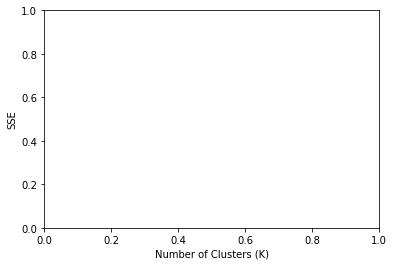

In [55]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages("coude_cluster.pdf") as pdf:
    cluster_number = range(2,10)
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("SSE")
    plt.scatter(cluster_number , errors)
    pdf.savefig()
    plt.close()



In [152]:
kmeans  = KMeans(featuresCol= "features" , k = 3)
model = kmeans.fit(features_df_iris)
model.transform(features_df_iris).groupBy("prediction").count().show()

predictions = model.transform(features_df_iris)
pandas_df = predictions.toPandas() 
pandas_df

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   50|
|         2|   38|
|         0|   62|
+----------+-----+



,Sp_L,Sp_W,P_L,P_W,Species,convert_target,features,prediction
0,5.1,3.5,1.4,0.2,Iris-setosa,0,"[5.1, 3.5, 1.4, 0.2]",1
1,4.9,3.0,1.4,0.2,Iris-setosa,0,"[4.9, 3.0, 1.4, 0.2]",1
2,4.7,3.2,1.3,0.2,Iris-setosa,0,"[4.7, 3.2, 1.3, 0.2]",1
3,4.6,3.1,1.5,0.2,Iris-setosa,0,"[4.6, 3.1, 1.5, 0.2]",1
4,5.0,3.6,1.4,0.2,Iris-setosa,0,"[5.0, 3.6, 1.4, 0.2]",1
...,...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica,2,"[6.7, 3.0, 5.2, 2.3]",2
146,6.3,2.5,5.0,1.9,Iris-virginica,2,"[6.3, 2.5, 5.0, 1.9]",0
147,6.5,3.0,5.2,2.0,Iris-virginica,2,"[6.5, 3.0, 5.2, 2.0]",2
148,6.2,3.4,5.4,2.3,Iris-virginica,2,"[6.2, 3.4, 5.4, 2.3]",2


In [130]:
predictions.show(3)

+----+----+---+---+-----------+--------------+-----------------+----------+
|Sp_L|Sp_W|P_L|P_W|    Species|convert_target|         features|prediction|
+----+----+---+---+-----------+--------------+-----------------+----------+
| 5.1| 3.5|1.4|0.2|Iris-setosa|             0|[5.1,3.5,1.4,0.2]|         1|
| 4.9| 3.0|1.4|0.2|Iris-setosa|             0|[4.9,3.0,1.4,0.2]|         1|
| 4.7| 3.2|1.3|0.2|Iris-setosa|             0|[4.7,3.2,1.3,0.2]|         1|
+----+----+---+---+-----------+--------------+-----------------+----------+
only showing top 3 rows



ValueError: setting an array element with a sequence.

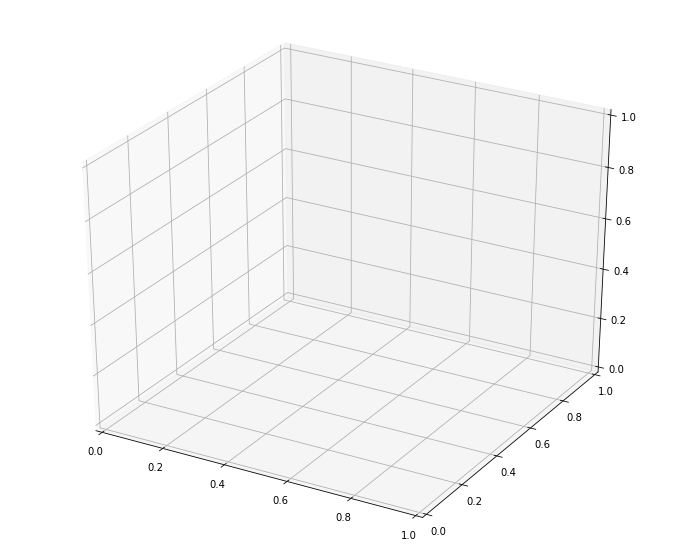

In [154]:
from mpl_toolkits.mplot3d import Axes3D

with PdfPages("kmeans_iris.pdf") as pdf:
    cluster_viz = plt.figure(figsize =(12,10)).gca(projection = "3d")
    cluster_viz.scatter(pandas_df.features , pandas_df.convert_target , c = pandas_df.prediction , depthshade = False)
    pdf.savefig()
    plt.close()



In [134]:
#taux d erreurs

results = predictions.select(["convert_target" , "prediction"])

#setosa
tp = results[results.convert_target ==0 & results.prediction == 1 ].count()
fp = results[results.convert_target ==0 & results.prediction != 1 ].count()

#versicolor
tp = results[results.convert_target ==1 & results.prediction == 2 ].count()
fp = results[results.convert_target ==1 & results.prediction != 1 ].count()

#virginica
tp = results[results.convert_target ==2 & results.prediction == 0 ].count()
fp = results[results.convert_target ==2 & results.prediction != 1 ].count()



Py4JError: An error occurred while calling o951.and. Trace:
py4j.Py4JException: Method and([class java.lang.Integer]) does not exist
	at py4j.reflection.ReflectionEngine.getMethod(ReflectionEngine.java:318)
	at py4j.reflection.ReflectionEngine.getMethod(ReflectionEngine.java:326)
	at py4j.Gateway.invoke(Gateway.java:274)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:832)



In [144]:
results = predictions.select(["convert_target" , "prediction"])
tp = results[results.convert_target == 0 & predictions.prediction == 1 ].count()

Py4JError: An error occurred while calling o1003.and. Trace:
py4j.Py4JException: Method and([class java.lang.Integer]) does not exist
	at py4j.reflection.ReflectionEngine.getMethod(ReflectionEngine.java:318)
	at py4j.reflection.ReflectionEngine.getMethod(ReflectionEngine.java:326)
	at py4j.Gateway.invoke(Gateway.java:274)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:832)



In [151]:
results.groupBy("convert_target" , "prediction").count().orderBy("convert_target").show()

+--------------+----------+-----+
|convert_target|prediction|count|
+--------------+----------+-----+
|             0|         1|   50|
|             1|         2|    2|
|             1|         0|   48|
|             2|         2|   36|
|             2|         0|   14|
+--------------+----------+-----+



In [32]:
####RANDOM FOREST####

In [33]:
myschema = StructType([StructField("User_ID", IntegerType(), True)\
                       ,StructField("Gender", StringType(), True)\
                       ,StructField("Age", IntegerType(), True)\
                       ,StructField("EstimatedSalary", IntegerType(), True)\
                       ,StructField("Purchased", IntegerType(), True)])

In [34]:
df_ads = spark.read.csv("Social_Network_Ads.txt" , sep = "," , header = True , schema = myschema)

In [35]:
df_ads.printSchema()

root
 |-- User_ID: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- EstimatedSalary: integer (nullable = true)
 |-- Purchased: integer (nullable = true)



In [36]:
print("dataset shape :" , df_ads.shape())

dataset shape : (400, 5)


In [37]:
import pyspark.sql.functions as F
from functools import reduce

cols = ["Gender"]
df_ads = reduce(lambda df_ads, c: df_ads.withColumn(c, F.when(df_ads[c] == 'Male', 0).otherwise(1)), cols, df_ads)

In [38]:
df_ads.show(3)

+--------+------+---+---------------+---------+
| User_ID|Gender|Age|EstimatedSalary|Purchased|
+--------+------+---+---------------+---------+
|15624510|     0| 19|          19000|        0|
|15810944|     0| 35|          20000|        0|
|15668575|     1| 26|          43000|        0|
+--------+------+---+---------------+---------+
only showing top 3 rows



In [39]:
df_ads.groupBy("Purchased").count().show(3)
df_ads.groupBy("Gender" , "Purchased").count().orderBy("Gender" , "Purchased" , "count" , ascending = False).show(3)
df_ads.groupBy("Purchased").mean().show()

+---------+-----+
|Purchased|count|
+---------+-----+
|        1|  143|
|        0|  257|
+---------+-----+

+------+---------+-----+
|Gender|Purchased|count|
+------+---------+-----+
|     1|        1|   77|
|     1|        0|  127|
|     0|        1|   66|
+------+---------+-----+
only showing top 3 rows

+---------+--------------------+-------------------+------------------+--------------------+--------------+
|Purchased|        avg(User_ID)|        avg(Gender)|          avg(Age)|avg(EstimatedSalary)|avg(Purchased)|
+---------+--------------------+-------------------+------------------+--------------------+--------------+
|        1|1.5692222902097901E7| 0.5384615384615384| 46.39160839160839|   86272.72727272728|           1.0|
|        0|1.5691159642023345E7|0.49416342412451364|32.793774319066145|   60544.74708171206|           0.0|
+---------+--------------------+-------------------+------------------+--------------------+--------------+



In [40]:
from pyspark.ml.feature import VectorAssembler

df_assemblor = VectorAssembler(inputCols = ["Gender" , "Age" , "EstimatedSalary" , "Purchased"] , outputCol = "features")
features_ads = df_assemblor.transform(df_ads)

features_ads.show(3)

+--------+------+---+---------------+---------+--------------------+
| User_ID|Gender|Age|EstimatedSalary|Purchased|            features|
+--------+------+---+---------------+---------+--------------------+
|15624510|     0| 19|          19000|        0|[0.0,19.0,19000.0...|
|15810944|     0| 35|          20000|        0|[0.0,35.0,20000.0...|
|15668575|     1| 26|          43000|        0|[1.0,26.0,43000.0...|
+--------+------+---+---------------+---------+--------------------+
only showing top 3 rows



In [47]:
model_df_ads = features_ads.select(["features" , "Purchased"])

train_df_ads , test_df_ads = model_df_ads.randomSplit([0.8,0.2])
train_df_ads.shape()

(330, 2)

In [48]:
test_df_ads.groupBy("Purchased").count().show()

+---------+-----+
|Purchased|count|
+---------+-----+
|        1|   22|
|        0|   48|
+---------+-----+



In [53]:
from pyspark.ml.classification import RandomForestClassifier
randomforest_classifier = RandomForestClassifier(labelCol = "Purchased" , numTrees=20).fit(train_df_ads)

randomforest_predictions = randomforest_classifier.transform(test_df_ads)
randomforest_predictions.show()

randomforest_predictions.groupBy("prediction").count().show()

+--------------------+---------+--------------------+--------------------+----------+
|            features|Purchased|       rawPrediction|         probability|prediction|
+--------------------+---------+--------------------+--------------------+----------+
|[0.0,21.0,88000.0...|        0|          [20.0,0.0]|           [1.0,0.0]|       0.0|
|[0.0,25.0,22000.0...|        0|          [20.0,0.0]|           [1.0,0.0]|       0.0|
|[0.0,25.0,33000.0...|        0|          [20.0,0.0]|           [1.0,0.0]|       0.0|
|[0.0,25.0,90000.0...|        0|          [20.0,0.0]|           [1.0,0.0]|       0.0|
|[0.0,29.0,75000.0...|        0|          [20.0,0.0]|           [1.0,0.0]|       0.0|
|[0.0,29.0,80000.0...|        0|          [20.0,0.0]|           [1.0,0.0]|       0.0|
|[0.0,30.0,15000.0...|        0|          [20.0,0.0]|           [1.0,0.0]|       0.0|
|[0.0,30.0,17000.0...|        0|          [20.0,0.0]|           [1.0,0.0]|       0.0|
|[0.0,31.0,58000.0...|        0|          [20.0,0.0]| 

In [54]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
randomforest_classifier_accuracy = MulticlassClassificationEvaluator(labelCol = "Purchased" , metricName = "accuracy").evaluate(randomforest_predictions)

print("random Forest accuracy : {0:.0%}".format(randomforest_classifier_accuracy))

random Forest accuracy : 100%
